Estimating the effect of a Member Rewards program





An example on how DoWhy can be used to estimate the effect of a subscription or a rewards program for customers.

Suppose that a website has a membership rewards program where customers receive additional benefits if they sign up. How do we know if the program is effective? Here the relevant causal question is: > What is the impact of offering the membership rewards program on total sales?

And the equivalent counterfactual question is, > If the current members had not signed up for the program, how much less would they have spent on the website?

In formal language, we are interested in the Average Treatment Effect on the Treated (ATT).

In [8]:
# Creating some simulated data for our example
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,442,False
1,0,0,2,494,False
2,0,0,3,482,False
3,0,0,4,444,False
4,0,0,5,432,False
...,...,...,...,...,...
119995,9999,2,8,467,True
119996,9999,2,9,507,True
119997,9999,2,10,536,True
119998,9999,2,11,492,True


In [9]:
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       468.0   420.777778
1           1             0      False       498.0   423.333333
2           2             0      False       500.5   431.888889
3           7             0      False       497.0   418.111111
4           8             0      False       501.0   414.555556
...       ...           ...        ...         ...          ...
5452     9990             0      False       478.0   422.888889
5453     9993             0      False       512.5   431.111111
5454     9995             0      False       460.5   428.555556
5455     9996             0      False       482.0   417.555556
5456     9998             0      False       482.5   404.555556

[5457 rows x 5 columns]


c:\Users\Ali\miniconda3\envs\case\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


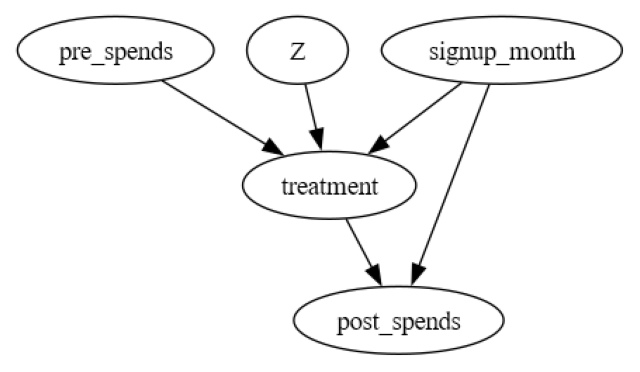

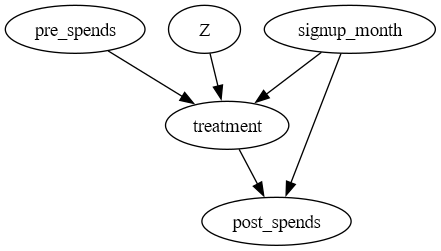

In [10]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

II. Identifying the causal effect

In [11]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[Z  pre_spends]              ⎝d[Z  pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z,pre_spends})
Estimand assumption 2, Exclusion: If we remove {Z,pre_spends}→{treatment}, then ¬({Z,pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [12]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 99.09502923976612



In [13]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:99.09502923976612
New effect:-1.322173489278744
p value:0.04464853436673244

